In [75]:
import glob
from itertools import product
import os

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns


In [95]:

def get_dataset_characteristics(dataset_path):
    df = pd.read_csv(dataset_path)
    n_samples, n_cols = df.shape

    # ...

    return n_cols, n_samples


def get_correlation_distribution(df: pd.DataFrame, how='max'):
    assert how in ['all', 'median', 'mean', 'max', 'min']
    corr_df = df.corr()
    if how == 'all':
        relevant_entries = [
            (x, y) 
            for x, y in product(range(corr_df.shape[0]), range(corr_df.shape[1]))
            if x < y
        ]
        correlations = [corr_df.iloc[relevant_entries[i]] for i in range(len(relevant_entries))]
        return correlations
    else:
        abs_corr_df = df.corr().abs()
        abs_corr_df.values[[np.arange(abs_corr_df.shape[0])]*2] = abs_corr_df.median(axis=0)
        stat_corrs = eval('abs_corr_df.{}(axis=0)'.format(how))
        return stat_corrs


def plot_correlation_distribution(df=None, correlations=None, title='', color='blue', how='all'):
    if df is not None:
        # correlations = get_correlation_distribution(df)
        correlations = get_correlation_distribution(df, how=how)
    assert correlations is not None
    sns.histplot(correlations, stat='percent', color=color, multiple='stack')
    

In [139]:
def get_clf_diversity_impact_single_experiment(experiment_trial_dir, n_baselines=8, n_ensembles=5):
    preds_df = pd.read_csv(os.path.join(experiment_trial_dir, 'results', 'predictions_0.csv'), index_col=0)
    std_per_sample = preds_df.iloc[:, 0: n_baselines].std(axis=1)
    overall_diversity = np.mean(std_per_sample)
    metrics_df = pd.read_csv(os.path.join(experiment_trial_dir, 'final_results.csv'), index_col=0)
    
    ensembles_aucs = metrics_df.iloc[0, -n_ensembles:]
    ensembles_aucs['dew_full_outperforms_uniform'] = ensembles_aucs['dew_top_None'] - ensembles_aucs['Uniform Model Averaging'] 
    ensembles_aucs['dew_top_1_outperforms_uniform'] = ensembles_aucs['dew_top_1'] - ensembles_aucs['Uniform Model Averaging'] 
    ensembles_aucs['dew_top_3_outperforms_uniform'] = ensembles_aucs['dew_top_3'] - ensembles_aucs['Uniform Model Averaging'] 
    return overall_diversity, ensembles_aucs


def get_dataset_size_impact_single_experiment(experiment_trial_dir, df, n_ensembles=5):
    metrics_df = pd.read_csv(os.path.join(experiment_trial_dir, 'final_results.csv'), index_col=0)
    ensembles_aucs = metrics_df.iloc[0, -n_ensembles:]
    ensembles_aucs['dew_full_outperforms_uniform'] = ensembles_aucs['dew_top_None'] - ensembles_aucs['Uniform Model Averaging'] 
    ensembles_aucs['dew_top_1_outperforms_uniform'] = ensembles_aucs['dew_top_1'] - ensembles_aucs['Uniform Model Averaging'] 
    ensembles_aucs['dew_top_3_outperforms_uniform'] = ensembles_aucs['dew_top_3'] - ensembles_aucs['Uniform Model Averaging'] 
    n_samples = df.shape[0]
    return n_samples, ensembles_aucs

## Analysis

In [147]:
import sys
sys.path.append('../src')
from data_loaders import DataLoadersEnum

CURRENT_SUPPORTED_DATALOADERS = {
    'eeg_eye_state': DataLoadersEnum.prepare_eeg_eye_data,
    'Cleveland Heart Disease': DataLoadersEnum.prepare_cleveland_heart_data,
    'diabetic_retinopathy': DataLoadersEnum.prepare_diabetic_retinopathy_dataset,
    'wpbc': DataLoadersEnum.prepare_wpbc_data,
    'wdbc': DataLoadersEnum.prepare_wdbc_data,
    'parkinsons': DataLoadersEnum.prepare_parkinsons_data,
    'cervical_cancer': DataLoadersEnum.prepare_cervical_cancer_data,
    'myocardial_infarction': DataLoadersEnum.prepare_myocardial_infarction_data
}

/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/diabetic_retinopathy_final/MNAR_Experiment_2022-08-16 15:32:56.846367/MNAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/diabetic_retinopathy_final/MAR_Experiment_2022-08-16 15:24:22.078615/MAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/diabetic_retinopathy_final/MCAR_Experiment_2022-08-16 15:15:03.445669/MCAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/eeg_eye_state/MCAR_Experiment_2022-08-16 15:45:56.188662/MCAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/eeg_eye_state/MAR_Experiment_2022-08-16 23:00:10.729475/MAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/wisconsin_bc_diagnosis/MCAR_Experiment_2022-09-09 13:21:35.626704/MCAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials/wisconsin_bc_diagnosis/MAR_Experiment_2022-09-09 13:30:31.870045/MAR
/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Exper

/Users/adamcatto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'DEW-Uniform Discrepancy vs. Number of samples')

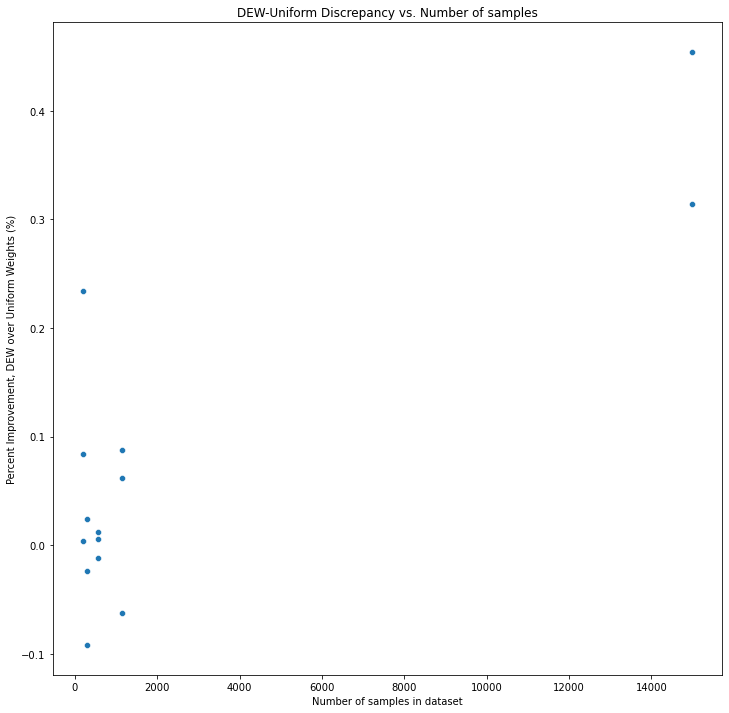

In [151]:
exp_dir = '/Users/adamcatto/Dropbox/CUNY/Research/dynamime/Experiment_Trials'
experiment_types = ['diabetic_retinopathy_final', 'eeg_eye_state', 'wisconsin_bc_diagnosis', 'wisconsin_bc_prognosis', 'cleveland_heart_disease']
corresponding_dataloaders = [
    DataLoadersEnum.prepare_diabetic_retinopathy_dataset,
    DataLoadersEnum.prepare_eeg_eye_data,
    DataLoadersEnum.prepare_wdbc_data,
    DataLoadersEnum.prepare_wpbc_data,
    DataLoadersEnum.prepare_cleveland_heart_data
]

exp_to_loader_mapping = {k: v for k, v in zip(experiment_types, corresponding_dataloaders)}

exps = [os.path.join(exp_dir, exp_type) for exp_type in experiment_types]
all_exp_dirs = []
for exp in exps:
    all_exp_dirs += list(glob.glob(os.path.join(exp, '**', '**')))

all_n_samples = []
all_aucs = []
all_diversity_scores = []

for e in all_exp_dirs:
    print(e)
    diversity_score, aucs = get_clf_diversity_impact_single_experiment(e)
    custom_exp_object = exp_to_loader_mapping[e.split('/')[8]]()
    df = custom_exp_object[0]
    n_samples, aucs = get_dataset_size_impact_single_experiment(experiment_trial_dir=e, df=df)
    all_diversity_scores.append(diversity_score)
    all_n_samples.append(n_samples)
    all_aucs.append(aucs['dew_full_outperforms_uniform'])
    
plt.figure(figsize=(12,12))
sns.scatterplot(all_n_samples, np.array(all_aucs)*100)
plt.ylabel('Percent Improvement, DEW over Uniform Weights (%)')
plt.xlabel('Number of samples in dataset')
plt.title('DEW-Uniform Discrepancy vs. Number of samples')
    

/Users/adamcatto/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'DEW-Uniform Discrepancy vs. Classifier Diversity')

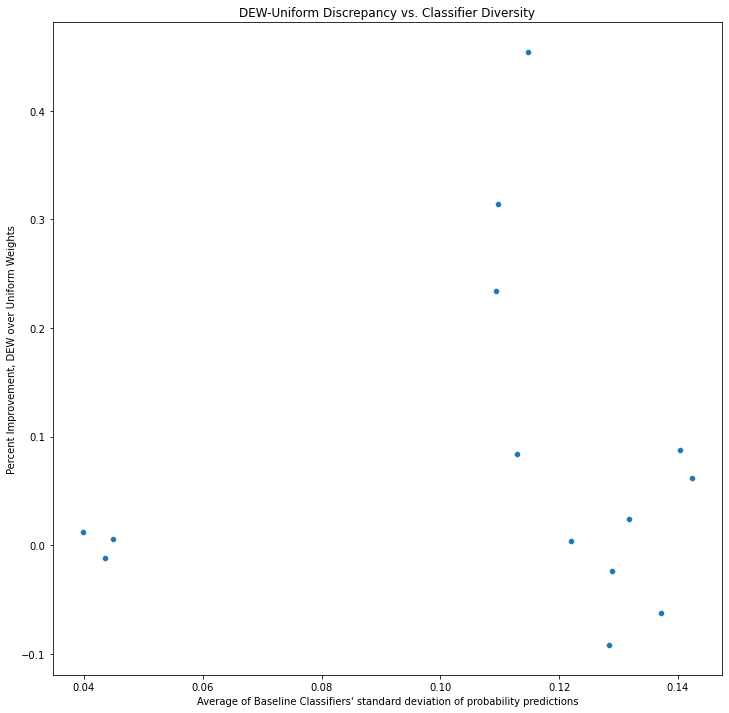

In [152]:
plt.figure(figsize=(12,12))
sns.scatterplot(all_diversity_scores, np.array(all_aucs)*100)
plt.ylabel('Percent Improvement, DEW over Uniform Weights')
plt.xlabel("Average of Baseline Classifiers' standard deviation of probability predictions")
plt.title('DEW-Uniform Discrepancy vs. Classifier Diversity')

In [160]:
exp_names = []
miss_types = []
exp_type_list = []
ensemble_auc_scores = []

for e in all_exp_dirs:
    exp_names.append(e.split('/')[8] + '__' + e.split('/')[-1])
    exp_type_list.append(e.split('/')[8])
    miss_types.append(e.split('/')[-1])
    metrics_df = pd.read_csv(os.path.join(e, 'final_results.csv'), index_col=0)
    ensemble_aucs = metrics_df.iloc[0,-5:]
    ensemble_auc_scores.append(np.ravel(ensemble_aucs))
    
df = pd.DataFrame(np.vstack(ensemble_auc_scores))
df.columns = ensemble_aucs.index
df = df.rename(columns={"<class 'sklearn.ensemble._stacking.StackingClassifier'>": 'stacked'})
df.index = exp_names
df.index.name = 'experiment AUROC Scores'
df *= 100
df

,Uniform Model Averaging,stacked,dew_top_1,dew_top_3,dew_top_None
experiment AUROC Scores,,,,,
diabetic_retinopathy_final__MNAR,72.598,64.256,70.160,72.638,72.660
diabetic_retinopathy_final__MAR,74.370,68.338,70.926,73.450,74.308
diabetic_retinopathy_final__MCAR,73.184,65.800,69.206,72.244,73.272
eeg_eye_state__MCAR,83.482,82.392,82.694,84.708,83.796
eeg_eye_state__MAR,86.548,86.566,86.174,88.096,87.002
wisconsin_bc_diagnosis__MCAR,98.926,96.738,98.764,98.848,98.932
wisconsin_bc_diagnosis__MAR,99.026,98.090,98.670,98.878,99.038
wisconsin_bc_diagnosis__MNAR,99.286,96.766,98.930,99.148,99.274
wisconsin_bc_prognosis__MCAR,58.856,49.346,53.754,59.512,58.940


['../data/', '../data/diabetic_retinopathy_dataset.csv', '../data/wpbc.names', '../data/wdbc.names', '../data/risk_factors_cervical_cancer.csv', '../data/MI.data', '../data/parkinsons', '../data/parkinsons/train_data.txt', '../data/parkinsons/test_data.txt', '../data/diabetes_vcu.csv', '../data/eeg_eye_state.csv', '../data/wdbc.data', '../data/wpbc.data', '../data/heart_cleveland_upload.csv']


/var/folders/j7/gbh6cfvd385f76826jf15f_c0000gn/T/ipykernel_30500/460945964.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  abs_corr_df.values[[np.arange(abs_corr_df.shape[0])]*2] = abs_corr_df.median(axis=0)
/var/folders/j7/gbh6cfvd385f76826jf15f_c0000gn/T/ipykernel_30500/460945964.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  abs_corr_df.values[[np.arange(abs_corr_df.shape[0])]*2] = abs_corr_df.median(axis=0)
/var/folders/j7/gbh6cfvd385f76826jf15f_c0000gn/T/ipykernel_30500/460945964.py:23: FutureWarning: Using a non-tuple seq

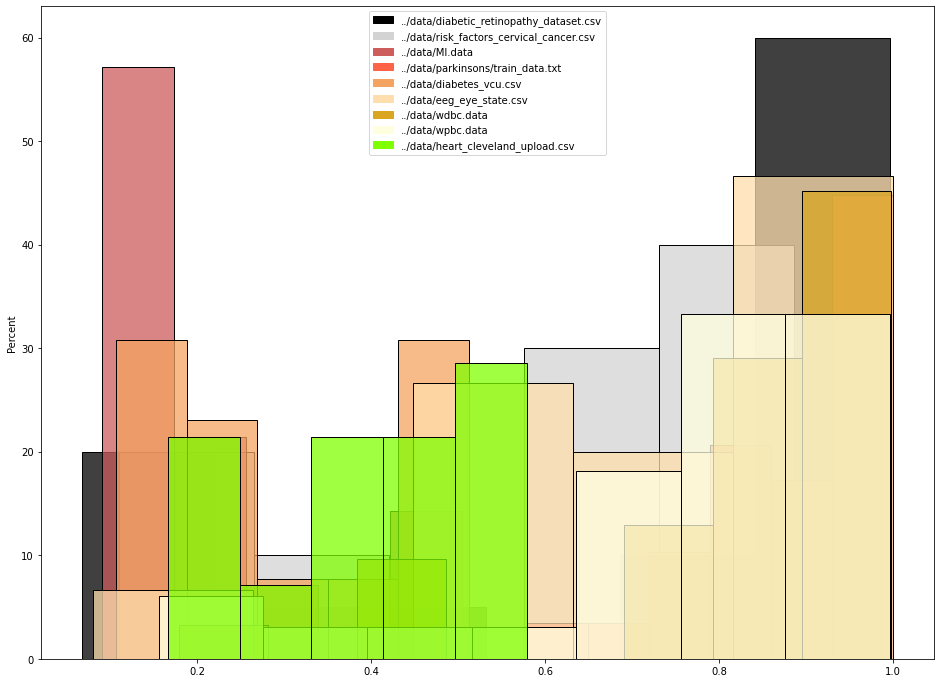

In [153]:
# from data_loaders import DataLoadersEnum

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

files = glob.glob('../data/**', recursive=True)
print(files)
usable_files = []

for f in files:
    try:
        _ = pd.read_csv(f)
        usable_files.append(f)
    except:
        continue

usable_files.remove('../data/parkinsons/test_data.txt')
n_usable_files = len(usable_files)

colors_used = [sorted_names[i] for i in range(0,len(sorted_names), n_usable_files)]
patches = [mpatches.Patch(color=c, label=f) for c, f in zip(colors_used, usable_files)]

plt.figure(figsize=(16,12))

for i, f in enumerate(usable_files):
    try:
        # df = pd.read_csv('../data/parkinsons/train_data.txt', header=None, index_col=0)
        df = pd.read_csv(f)
        plot_correlation_distribution(df=df, title=f, color=colors_used[i], how='max')
    except Exception as e:
        print(f, e)
        
plt.legend(handles = patches)
plt.show()

In [ ]:
LSAC DAtaset
student performance dataset